# funcx_synth2 run analysis

Using just the data I can already extract... without falling into the temptation to modify funcx

In [103]:
import matplotlib.pyplot as plt
import sqlite3

## open the database

In [104]:
db = sqlite3.connect("dnpc.sqlite3")
c = db.cursor()

# count how many different span types are in the database

In [105]:
for row in c.execute("SELECT type, COUNT(type) FROM span GROUP BY type"):
    print(row)

('cloudwatch.task', 1000)
('synthetic.task.submit', 1000)
('synthetic.task.worker', 1000)


## funcX, without any parsl

funcX is not built for being monitored.

There are three broad sources of data that a user might have access to.

i) on their submit side, they might record their own timing information (or turn on logging for the funcX submitting code), giving them some data in a log file or database

ii) the relevant funcX endpoint(s) know about task execution and if correctly configured will log out a lot of data

iii) the centrally hosted services know about every task and log some information to cloudwatch

Any given monitoring user will have access to one of the seven possible non-empty subsets of this information, and it would be useful to be able to make whichever analyses are possible in all seven situations - there should be "graceful degradation" of monitoring power.

In [106]:
# so to begin with, as a submitter, without any access either to endpoint or central service logs, what
# sort of information can I see?

# Here are two sources:
# i) I can collect timings of submitting tasks and collecting results
# ii) I can collect timings inside my remote task, and return those timings as part of the result.

# I can then import those into the database, and make similar looking queries against them.

# This notebook does not show the import, but assumes by this stage an import has been done

# This data can exist alongside the above parsl/work queue related data in the same database.
# The records do not conflict.

# This is an example of higher-level application specific monitoring data: the component we are using (funcx)
# doesn't really know what's being monitored, and there isn't any particularly live monitoring system at the
# time of execution, beyond a few log statements.
# So there (necessarily?) is a custom importer, reflecting that the code to record the monitoring info is custom.

## how long does the application worker thinks tasks took?

In [107]:
sql= """
select start_event.time as start,
       end_event.time as end,
       end_event.time - start_event.time

  from span,
       event as start_event,
       event as end_event

 where span.type='synthetic.task.worker'

   and start_event.span_uuid = span.uuid
   and start_event.type = 'start'

   and end_event.span_uuid = span.uuid
   and end_event.type = 'end'
;"""

sql= """
select span.uuid, start_event.time, end_event.time, end_event.time - start_event.time
from span, 
     event as start_event,
     event as end_event
where span.type = 'synthetic.task.worker'
  and start_event.span_uuid = span.uuid
  and start_event.type = 'start'
  and end_event.span_uuid = span.uuid
  and end_event.type <> 'start'

"""
rows = list(c.execute(sql))
print(f"count of rows: {len(rows)}")
print(f"first row: {rows[0]}")


count of rows: 1000
first row: ('b0431e14-3c67-49cb-9f55-0e86e83ee9c3', '1659518799.21804', '1659518799.21804', 0.0)


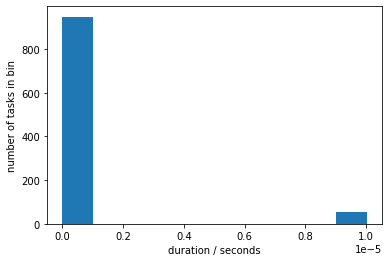

In [108]:
durations = [r[3] for r in rows]

plt.hist(durations)
plt.xlabel("duration / seconds")
plt.ylabel("number of tasks in bin")
plt.show()

count of rows: 1000
first row: ('f0dd5bef-0668-4d73-9de2-205b46c753f3', '1659518795.71679', '1659518799.37267', 3.6558799743652344)


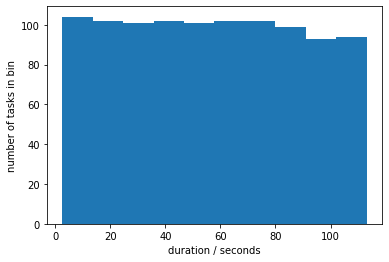

In [109]:

sql= """
select span.uuid, start_event.time, end_event.time, end_event.time - start_event.time
from span, 
     event as start_event,
     event as end_event
where span.type = 'synthetic.task.submit'
  and start_event.span_uuid = span.uuid
  and start_event.type = 'submit'
  and end_event.span_uuid = span.uuid
  and end_event.type = 'result_retrieved'

"""
rows = list(c.execute(sql))
print(f"count of rows: {len(rows)}")
print(f"first row: {rows[0]}")
durations = [r[3] for r in rows]

plt.hist(durations)
plt.xlabel("duration / seconds")
plt.ylabel("number of tasks in bin")
plt.show()

In [110]:
# That's probably because we don't checking for results until everything has been submitted - so a bunch of
# could complete in this time?

In [111]:
# let's see what the time difference looks like between the worker side ending and the result being processed
# on the submit side.

# to do that, we need to join the two spans together somehow.

# in the log file, we have a task number for both types of span, so we can use that to create a link between
# the two in the database.

# there's a sort of natural hierarchy here: the remote execution could be regarded as "inside" the submit side
# code. if we're going to believe that argument, the the remote span should be a subspan of the submit span.
# and the importer should be made to represent that in the `subspan` table.

1000
(23.97070002555847,)


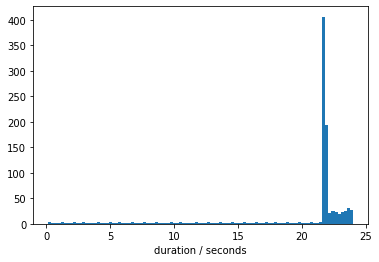

In [112]:
sql= """
select end_event.time - start_event.time
from span as submit_span,
     span as remote_span,
     event as start_event,
     event as end_event,
     subspan
where remote_span.type = 'synthetic.task.worker'
  and submit_span.type = 'synthetic.task.submit'
  and start_event.span_uuid = remote_span.uuid
  and start_event.type = 'end'
  and end_event.span_uuid = submit_span.uuid
  and end_event.type = 'result_retrieved'
  and subspan.superspan_uuid = submit_span.uuid
  and subspan.subspan_uuid = remote_span.uuid
"""
rows = list(c.execute(sql))
print(len(rows))
print(rows[-1])
durations = [r[0] for r in rows]

plt.hist(durations, bins=100)
plt.xlabel("duration / seconds")
plt.show()

In [113]:
# I suspect that this is happening with the early tasks, and I could
# plot that as a scatter of the two variables, rather than a histogram
# of the difference.

# so broadly the same SQL query as above, but returning the two values
# to use as coordinates, rather than collapsing them into a single value
# using minus.

1000
('1659518799.21804', '1659518799.37267')


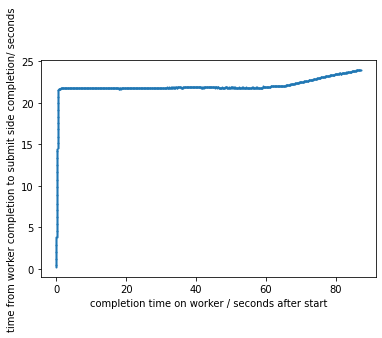

In [114]:
sql= """
select start_event.time, end_event.time
from span as submit_span,
     span as remote_span,
     event as start_event,
     event as end_event,
     subspan
where remote_span.type = 'synthetic.task.worker'
  and submit_span.type = 'synthetic.task.submit'
  and start_event.span_uuid = remote_span.uuid
  and start_event.type = 'end'
  and end_event.span_uuid = submit_span.uuid
  and end_event.type = 'result_retrieved'
  and subspan.superspan_uuid = submit_span.uuid
  and subspan.subspan_uuid = remote_span.uuid
"""
rows = list(c.execute(sql))
print(len(rows))
print(rows[0])

x = [float(r[0]) for r in rows]
x_min = min(x)
x = [v - x_min for v in x]
y = [float(r[1]) - float(r[0]) for r in rows]


plt.ylabel("time from worker completion to submit side completion/ seconds")
plt.xlabel("completion time on worker / seconds after start")

plt.scatter(x=x, y=y, s=1)
plt.show()

In [115]:
# can we construct a tasks-in-each-state plot?
# which gives something with a feeling a bit like "queue length" but constructed from event data, rather than
# from asking particular data structures across the system what their queue length is - so it can capture
# unsubmitted tasks and completed tasks that don't live in a "queue" as such, as well as capturing overhead
# around real queues.

# in my other prototype, `plot_context_streamgraph` did this, with a bunch of processing to collect
# sub-events etc

# This graph is also what I then amended with span weight to give better visualisation of resource usage
# under work queue resource usage - when there is one dominant resource quantity (memory in the DESC case).
# Although you could plot a bunch of graphs, one for each, and see what's getting saturated.

In [116]:
# There's also some monitoring data available inside cloudwatch and in the relevant endpoint, in various
# (potentially awkward to extract) forms.

# From cloudwatch, we can get similar views without client side participation - for example, if there was a
# cloud-hosted presentation of a user's tasks. This might look similar to the above data, or might expose
# some performance problems in the whole stack.

# From the endpoint (which a third party, neither the user or funcX, might be running) we can get some
# task and worker utilisations, but without so much user side knowledge of how they were invoked and
# what they were.

# From cloudwatch, as well as tasks, we can also get some data about the endpoints

# for example, a CloudWatch query like this:
"""
fields @timestamp, @message
| sort @timestamp desc
| filter log_processed.task_group_id = "700a129f-0480-481b-b965-5c303bb16907"  # doesn't work
| limit 10000
"""
# can be imported - it takes 230 seconds to run over the last 3 weeks of data, giving 400 rows - so 4 rows
# per task.

'\nfields @timestamp, @message\n| sort @timestamp desc\n| filter log_processed.task_group_id = "700a129f-0480-481b-b965-5c303bb16907"  # doesn\'t work\n| limit 10000\n'

In [117]:
sql= """
select start_event.time, end_event.time
from span as submit_span,
     span as remote_span,
     event as start_event,
     event as end_event,
     subspan
where remote_span.type = 'synthetic.task.worker'
  and submit_span.type = 'synthetic.task.submit'
  and start_event.span_uuid = remote_span.uuid
  and start_event.type = 'end'
  and end_event.span_uuid = cloudwatch_span.uuid
  and end_event.type = ''
  and subspan.superspan_uuid = submit_span.uuid
  and subspan.subspan_uuid = remote_span.uuid
"""
rows = list(c.execute(sql))
print(len(rows))
print(rows[0])

x = [float(r[0]) for r in rows]
x_min = min(x)
x = [v - x_min for v in x]
y = [float(r[1]) - float(r[0]) for r in rows]


plt.ylabel("time from worker completion to submit side completion/ seconds")
plt.xlabel("completion time on worker / seconds after start")

plt.scatter(x=x, y=y, s=1)
plt.show()

OperationalError: no such column: cloudwatch_span.uuid

1000
('1659518799.293', '1659518799.37267')


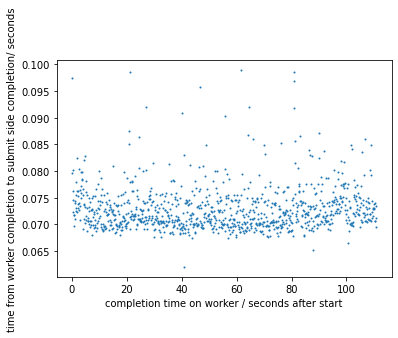

In [118]:
sql= """
select start_event.time, end_event.time
from span as submit_span,
     span as remote_span,
     event as start_event,
     event as end_event,
     subspan
where remote_span.type = 'cloudwatch.task'
  and submit_span.type = 'synthetic.task.submit'
  and start_event.span_uuid = remote_span.uuid
  and start_event.type = 'result_processor--result_received'
  and end_event.span_uuid = submit_span.uuid
  and end_event.type = 'result_retrieved'
  and subspan.superspan_uuid = submit_span.uuid
  and subspan.subspan_uuid = remote_span.uuid
"""
rows = list(c.execute(sql))
print(len(rows))
print(rows[0])

x = [float(r[0]) for r in rows]
x_min = min(x)
x = [v - x_min for v in x]
y = [float(r[1]) - float(r[0]) for r in rows]


plt.ylabel("time from worker completion to submit side completion/ seconds")
plt.xlabel("completion time on worker / seconds after start")

plt.scatter(x=x, y=y, s=1)
plt.show()

so from the result processor logging that it received the message, to the submit side code logging that it received the code, it is usually around 70ms. much nicer.

so there's some latency somewhere between the user app completing and the result received message being logged at the results processor.

so lets see if we can import endpoint logs for processing results

eg endpoint log lines like this:
```
1659518909.865638 2022-08-03 11:28:29 INFO MainProcess-220169 MainThread-140192181061440 funcx_endpoint.endpoint.interchange:357 _main_loop Passing result to forwarder for task f4a78c35-a548-416b-84f2-a3cde67e51c9
```

1000
('1659518799.22766', '1659518799.37267')


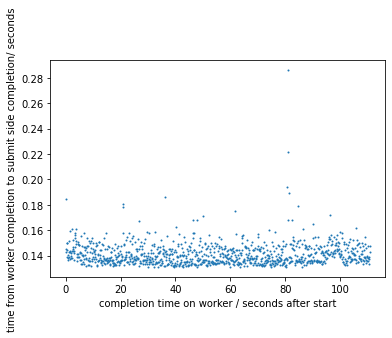

In [119]:
sql= """
select start_event.time, end_event.time
from span as submit_span,
     span as remote_span,
     event as start_event,
     event as end_event,
     subspan
where remote_span.type = 'cloudwatch.task'
  and submit_span.type = 'synthetic.task.submit'
  and start_event.span_uuid = remote_span.uuid
  and start_event.type = 'endpoint.forwarded'
  and end_event.span_uuid = submit_span.uuid
  and end_event.type = 'result_retrieved'
  and subspan.superspan_uuid = submit_span.uuid
  and subspan.subspan_uuid = remote_span.uuid
"""
rows = list(c.execute(sql))
print(len(rows))
print(rows[0])

x = [float(r[0]) for r in rows]
x_min = min(x)
x = [v - x_min for v in x]
y = [float(r[1]) - float(r[0]) for r in rows]


plt.ylabel("time from worker completion to submit side completion/ seconds")
plt.xlabel("completion time on worker / seconds after start")

plt.scatter(x=x, y=y, s=1)
plt.show()